# Smile Detection in Faces

In [7]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
    
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search
    !pip install ipywidgets


from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastai import *
import timm

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
    

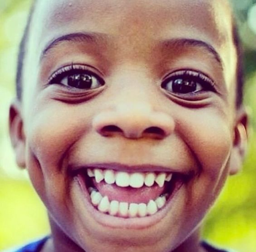

In [116]:
from fastdownload import download_url
dest = 'smile.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'human face upset photo'


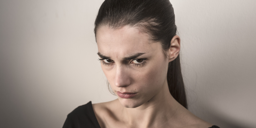

In [117]:
download_url(search_images('human face upset photo', max_images=1)[0], 'frown.jpg', show_progress=False)
Image.open('frown.jpg').to_thumb(256,256)

In [118]:
searches = 'human face happy','human face upset'
path = Path('images')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'), timeout=1000, max_pics=1000,n_workers=16)
    resize_images(path/o, max_size=300, dest=path/o)

Searching for 'human face happy photo'
Searching for 'human face upset photo'


In [119]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Manual Step: I trimmed all the pictures to be just faces and renamed the file to be "images_faces" so the previous steps wouldn't kill my hard work

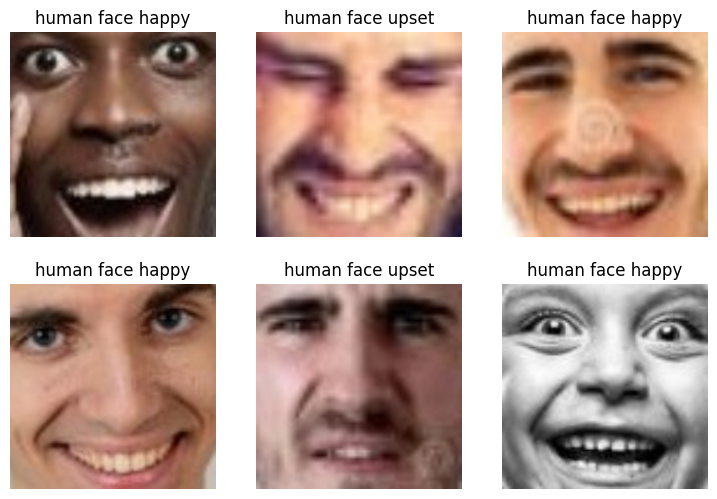

In [8]:
path = 'images_faces'

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=420),
    get_y=parent_label,
    item_tfms=[Resize(200, pad_mode=PadMode.Zeros)]
).dataloaders(path, bs=64)

dls.show_batch(max_n=6)

In [11]:
timm.list_models('convnext*')


['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [17]:
learn = vision_learner(dls, 'convnext_base_in22k', metrics=error_rate)
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,1.178948,3.555011,0.545455,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.831261,2.180188,0.545455,00:24
1,0.807159,1.381748,0.409091,00:24
2,0.776610,0.829547,0.272727,00:24
3,0.724362,0.928834,0.363636,00:24
4,0.625113,0.757080,0.227273,00:24
5,0.547172,0.389099,0.136364,00:24
6,0.479654,0.232712,0.181818,00:24
7,0.423880,0.200266,0.136364,00:24
8,0.375437,0.205977,0.045455,00:24
9,0.338784,0.213519,0.045455,00:24


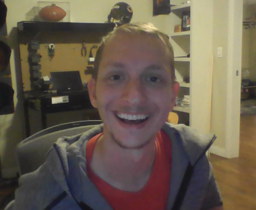

In [18]:
smile_image = PILImage.create('smile_test.jpg')
smile_image.to_thumb(256,256)

In [19]:
is_smile2,_2,probs2 = learn.predict(smile_image)
print(f"This is a: {is_smile2}.")
print(f"Probability: {probs2[0]:.4f}")

This is a: human face happy.
Probability: 0.9987


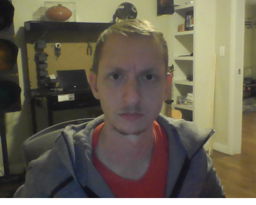

In [20]:
frown_image = PILImage.create('frown_test.jpg')
frown_image.to_thumb(256,256)

In [21]:
frown,_frown,probsfrown = learn.predict(frown_image)
print(f"This is a: {frown}.")
print(f"Probability: {probsfrown[0]:.4f}")

This is a: human face upset.
Probability: 0.0047


## Chapter 2 : Model to Production

In [22]:
learn.export()

I uploaded a webcam tester to huggingface and it works(ish. You need proper light and to really excentuate your facial movements). Try it yourself! https://huggingface.co/spaces/JonathonCwik/SmileOrFrown

![Smile](./blog_images/deploy_smile_example.png)

![Upset](./blog_images/deploy_upset_example.png)